In [1]:
import pickle
import numpy as np
import pandas as pd
import keras
import keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from keras import initializers, layers
from keras.callbacks import ModelCheckpoint
from keras.layers import Bidirectional, Dense, Dropout, Flatten
from keras.layers import GRU, Input
from keras.models import Model, load_model
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, f1_score

In [3]:
print(tf.__version__)
print(keras.__version__)

2.3.0
2.4.3


Setting up parameter globals

In [4]:
gru_len = 256
Routings = 5
Num_capsule = 2
Dim_capsule = 16
dropout_p = 0.3
rate_drop_dense = 0.3

batch_size = 512
recurrent_units = 64
dropout_rate = 0.5 
dense_size = 20
sentences_length = 50
fold_count = 10
max_features = 20000
maxlen = 1000
embed_size = 256

Non-linear activation fucntion for capsule layer

In [5]:
def squash(tensor, axis):
    s_norm = K.sum(K.square(tensor), axis, keepdims=True)
    scale = K.sqrt(s_norm + K.epsilon())
    return tensor / scale

Generating the capsule network algorithm with slight tweaks to optimize with the dataset


In [6]:
class CapsuleLayer(layers.Layer):
    
    def __init__(self, num_capsule, dim_capsule, routings=3,
                 kernel_initializer='glorot_uniform',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(shape=[self.num_capsule, self.input_num_capsule,
                                        self.dim_capsule, self.input_dim_capsule],
                                 initializer=self.kernel_initializer,
                                 name='W')

        self.built = True

    def call(self, inputs, training=None):
        
        inputs_expand = tf.expand_dims(inputs, 1)
        inputs_tiled  = tf.tile(inputs_expand, [1, self.num_capsule, 1, 1])
        inputs_tiled  = tf.expand_dims(inputs_tiled, 4)
        
        inputs_hat = tf.map_fn(lambda x: tf.matmul(self.W, x), elems=inputs_tiled)     

        # Begin: Routing algorithm ----------------------------------------------#
        b = tf.zeros(shape=[tf.shape(inputs_hat)[0], self.num_capsule, 
                            self.input_num_capsule, 1, 1])

        assert self.routings > 0, 'The routings should be > 0.'
        for i in range(self.routings):
            
            c = layers.Softmax(axis=1)(b)

            outputs = tf.multiply(c, inputs_hat)
            outputs = tf.reduce_sum(outputs, axis=2, keepdims=True)
            outputs = squash(outputs, axis=-2)  # [None, 10, 1, 16, 1]

            if i < self.routings - 1:

                outputs_tiled = tf.tile(outputs, [1, 1, self.input_num_capsule, 1, 1])
                agreement = tf.matmul(inputs_hat, outputs_tiled, transpose_a=True)
                b = tf.add(b, agreement)

        # End: Routing algorithm ------------------------------------------------#
        
        outputs = tf.squeeze(outputs, [2, 4])
        return outputs

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])

    def get_config(self):
        config = {
            'num_capsule': self.num_capsule,
            'dim_capsule': self.dim_capsule,
            'routings': self.routings
        }
        base_config = super(CapsuleLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

Tokenization

In [7]:
def char_replace(domain):

    domain = domain.replace("ç", "c")
    domain = domain.replace("Ç", "C")
    domain = domain.replace("à", "a")
    domain = domain.replace("Ä", "A")
    domain = domain.replace("ä", "a")
    domain = domain.replace("À", "A")
    domain = domain.replace("Â", "A")
    domain = domain.replace("â", "a")
    domain = domain.replace("é", "e")
    domain = domain.replace("è", "e")
    domain = domain.replace("É", "E")
    domain = domain.replace("È", "E")
    domain = domain.replace("Ë", "E")
    domain = domain.replace("ë", "e")
    domain = domain.replace("Ê", "E")
    domain = domain.replace("ê", "e")
    domain = domain.replace("û", "u")
    domain = domain.replace("Û", "U")
    domain = domain.replace("ü", "u")
    domain = domain.replace("Ü", "U")
    domain = domain.replace("ï", "i")
    domain = domain.replace("Ï", "I")
    domain = domain.replace("î", "i")
    domain = domain.replace("Î", "I")
    domain = domain.replace("Ô", "O")
    domain = domain.replace("ô", "o")
    domain = domain.replace("Ö", "O")
    domain = domain.replace("ö", "o")
    domain = domain.replace("Ù", "U")
    domain = domain.replace("ù", "u")
    domain = domain.replace("ÿ", "y")
    domain = domain.replace("æ", "ae")
    domain = domain.replace("_", " ")
    domain = domain.replace("\n", "")

    return domain

Reading dataset and Tokenizing the host urls

In [8]:
dframe = pd.read_csv('Datasets/dga_domains_full.csv', sep = ',')
dframe = pd.DataFrame(dframe)
df = dframe[["host","isDGA"]]
domains = df['host'].apply(lambda domain: char_replace(domain))
labels = df['isDGA']

In [9]:
labels.value_counts()

dga      100183
legit     99816
Name: isDGA, dtype: int64

In [10]:
all_letters = set(' '.join([str(i) for i in domains]))
all_letters.add("END")
len_letters = len(all_letters)

In [11]:
print(len_letters)

40


Character map creating, saving or loading

###############################################################
#
#       Don't run unless training new model        #
#
###############################################################

In [23]:
char_map = {v: k for k, v in enumerate(all_letters)}

In [24]:
def save_char_map(char_map):
    charmap = open('characterMap.pkl','ab')
    pickle.dump(char_map,charmap)
    charmap.close()

In [25]:
save_char_map(char_map)

# Run this for testing #

In [12]:
def load_char_map():
    charmap = open('characterMap.pkl','rb')
    char_map = pickle.load(charmap)
    charmap.close()
    return char_map

In [13]:
char_map = load_char_map()

In [14]:
print(char_map)

{'q': 0, 'g': 1, 'z': 2, 't': 3, 'l': 4, '.': 5, 'a': 6, 'y': 7, ' ': 8, 'f': 9, '7': 10, '9': 11, 'p': 12, 'j': 13, 'v': 14, 'i': 15, '2': 16, '6': 17, 'm': 18, 'k': 19, '-': 20, 'u': 21, '5': 22, 'w': 23, 'END': 24, 'x': 25, '8': 26, 'b': 27, 'n': 28, '0': 29, 'o': 30, 's': 31, '3': 32, 'e': 33, 'd': 34, 'h': 35, 'r': 36, 'c': 37, '1': 38, '4': 39}


Domain letter length plot

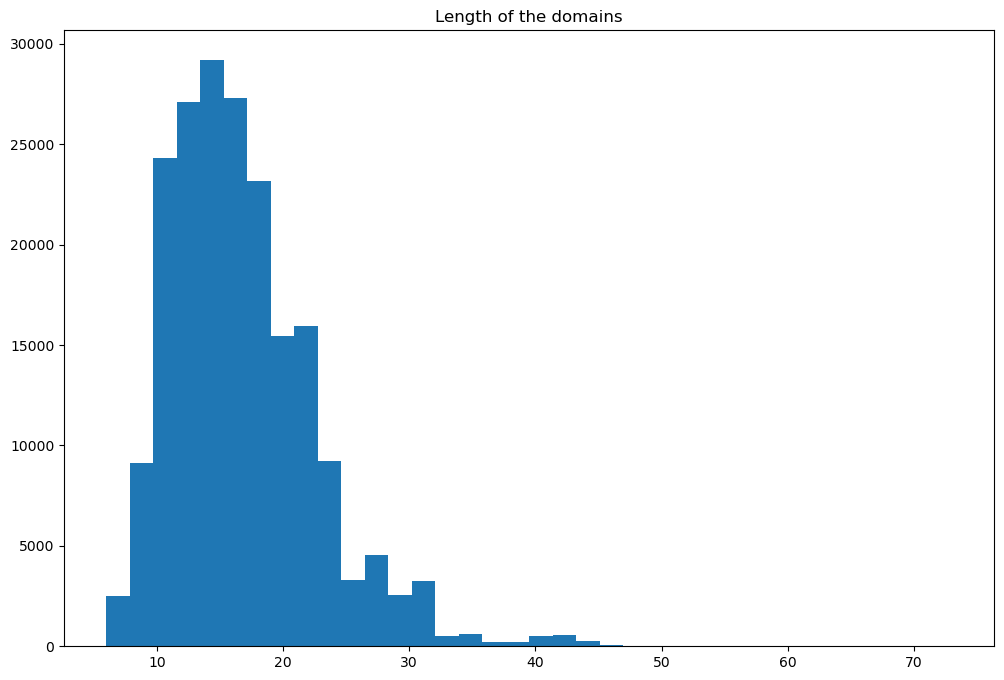

In [15]:
plt.figure(figsize=(12,8))
plt.hist([len(a) for a in domains], bins=36)
plt.title("Length of the domains")
plt.show()

Embedding the dataset in a character level

In [16]:
X = []
y = []

# Builds an empty line with a 1 at the index of character
def set_flag(i):
    temp = np.zeros(len_letters)
    temp[i] = 1
    return list(temp)

# Truncate names and create the matrix
def prepare_X(X):
    domain_list = []
    domain_truncs = [str(i)[0:sentences_length] for i in X]
    for i in domain_truncs:
        temp = [set_flag(char_map[j]) for j in str(i)]
        for k in range(0,sentences_length - len(str(i))):
            temp.append(set_flag(char_map["END"]))
        domain_list.append(temp)

    return domain_list

def prepare_y(y):
    label_list = []
    for i in y:
        if i == 'dga':
            label_list.append([1,0])
        else:
            label_list.append([0,1])

    return label_list


In [33]:
X = prepare_X(domains.values)

y = prepare_y(labels)

KeyboardInterrupt: 

Spliting training and testing values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

Casting train and test lists into numpy arrays of type float

In [ ]:
X_train = np.asarray(X_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')


In [ ]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

DL model

In [ ]:
def get_model(sequence_length, len_letters, dropout_rate, dense_size):
    inputs = Input(shape=(sequence_length,len_letters,))
    bi = Bidirectional(GRU(gru_len, activation='relu', dropout=dropout_rate, recurrent_dropout=dropout_rate, return_sequences=True),backward_layer=GRU(gru_len, return_sequences=True, go_backwards=True))(inputs)
    capsule = CapsuleLayer(num_capsule=Num_capsule, dim_capsule=Dim_capsule)(bi)
    capsule = Flatten()(capsule)
    capsule = Dropout(dropout_rate)(capsule)
    capsule = Dense(dense_size, activation='relu')(capsule)
    capsule = Flatten()(capsule)
    output = Dense(2, activity_regularizer=l2(0.002), activation='softmax')(capsule)
    model = Model(inputs=inputs, outputs=output, name="CapsDGA")
    return model

Monitoring and model saving

In [ ]:
mc = ModelCheckpoint('capsDGA_model.h5', monitor='accuracy', mode='max', verbose=1, save_best_only=True)

Getting the model object with the layers loaded in and getting the summary on it

In [ ]:
dgaModel = get_model(sentences_length, len_letters, dropout_rate, dense_size)
dgaModel.summary()

To get an idea on the models inputs and outputs

In [ ]:
[print(i.shape, i.dtype) for i in dgaModel.inputs]
[print(o.shape, o.dtype) for o in dgaModel.outputs]
[print(l.name, l.input_shape, l.dtype) for l in dgaModel.layers]

Compiling and fitting model

In [ ]:
optimizer = Adam(learning_rate=0.0008)
dgaModel.compile( loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
print("Starting to train models...")
dgaModel.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=40, verbose = 1, callbacks=mc)

Testing

In [ ]:
from layers.capsuleLayer import CapsuleLayer

In [17]:
model = load_model('capsDGA_model.h5',custom_objects={'CapsuleLayer': CapsuleLayer})

In [18]:
model.summary()

Model: "CapsDGA"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 50, 40)]          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 512)           457728    
_________________________________________________________________
capsule_layer (CapsuleLayer) (None, 2, 16)             819200    
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                660       
_________________________________________________________________
flatten_1 (Flatten)          (None, 20)                0   

In [19]:
domains_to_test = ["mskqpaiq.biz", "google.com", "appleborderlackentrancedump.com"]
X_pred = prepare_X([char_replace(e) for e in domains_to_test])

In [42]:
prediction = model.predict(X_pred)
prediction

array([[9.9999976e-01, 2.7499044e-07],
       [4.6046836e-05, 9.9995399e-01],
       [9.9999702e-01, 2.9904857e-06]], dtype=float32)

In [37]:
#prediction = list(prediction)
#for i in prediction:
#print(prediction)

In [47]:
def pred(domains, prediction):
    return_results = []
    index = 0
    for i in prediction:
        if i[0] > i[1]:
            return_results.append([domains[index], "DGA"])
        else:
            return_results.append([domains[index], "Benign"])
        index += 1
    return return_results

In [55]:
ok = pred(domains_to_test, prediction)
print(len(domains_to_test))

3


In [ ]:
pred = model.predict(X_test)

In [ ]:
predsacc = []
for predings in pred:
    if predings[0] > predings[1]:
        predsacc.append(1)
    else:
        predsacc.append(0)

predsaccy = []
for predings in y_test:
    if predings[0] > predings[1]:
        predsaccy.append(1)
    else:
        predsaccy.append(0)



In [ ]:
predsacc = np.asarray(predsacc).astype('float32')
predsaccy = np.asarray(predsaccy).astype('float32')
print(predsacc)
print(predsaccy)

AUCROC Testing

In [ ]:
roc_auc = roc_auc_score(y_test, pred)
print("The AUCROC Value : ", roc_auc)

F1 Score Testing

In [ ]:
f1 = f1_score(predsaccy,predsacc)
print("The F1 score : ", f1)

Summary

In [ ]:
thresholds = classification_report(predsaccy, predsacc)

In [ ]:
print(thresholds)